<a id="toc"></a>
# Deimos beamline spectral transmission

[rafael.celestre@synchrotron-soleil.fr](mailto:rafael.celestre@synchrotron-soleil.fr)

Contents :
1. [M1 system](#m1)
1. [Monochromator](#mono)
    1. [G1600](#G1600)
    1. [G2400](#G2400)
1. [Wolter focusing system](#wolter)
1. [Photon flux](#flux)
1. [Ideas for DEIMOS-II](#deimosii)
***

In [113]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '09/05/2024'
__changed__ = '21/10/2024'

import re
import sys
from glob import glob
from typing import Dict, List

import h5py as h5
import numpy as np
import scipy.integrate as integrate
from barc4plots.barc4plots import PlotManager
from barc4xoc.aux_carpem import load_carpem_dataset
from barc4xoc.grating import align_grating
from barc4xoc.materials import ml_reflectivity_curve, reflectivity_curve
from barc4xoc.misc import energy_wavelength
from barc4xoc.plots import plot_tuning_curve
from matplotlib.pylab import cm
from scipy.constants import physical_constants

CHARGE = physical_constants["atomic unit of charge"][0]

# checking we are using the correct python:
print(sys.executable)
print(sys.version)

# %matplotlib widget


c:\Users\rafae\miniconda3\envs\PyOptiX\python.exe
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


<a id="m1"></a>
## M1 system
[Back to the top](#toc)

Current mirrors have either Pt (M1A/M1B) or Rh (M1C) coatings. Incident angles are either $\theta=1.19°$ or 
$\theta=2.53°$.

In [ ]:
e0, ei, ef, dE = 0, 250, 5000, 5
ne = int((ef-ei)/dE)+1
energy = np.linspace(ei, ef, ne)

In [ ]:
Pt_1p19 = reflectivity_curve("Pt", -1, 1.19, ei, ef, ne)
Pt_2p53 = reflectivity_curve("Pt", -1, 2.53, ei, ef, ne)
Rh_1p20 = reflectivity_curve("Rh", -1, 1.19, ei, ef, ne)

In [ ]:
fig = PlotManager()

fig.image, fig.x = Pt_2p53["reflectivity"]**2, Pt_2p53["energy"]
fig.additional_info("M1 throughput", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{Pt_2p53["material"]} $\\times$ {Pt_2p53["material"]} @ {Pt_2p53["theta"]:.2f}°').plot_1d(enable=False)
fig.image, fig.x = Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"], Pt_1p19["energy"]
fig.info_1d_plot(1, f'{Pt_1p19["material"]} $\\times$ {Rh_1p20["material"]} @ {Pt_1p19["theta"]:.2f}°').plot_1d(enable=True, hold=True)


<a id="mono"></a>
## Monochromator
[Back to the top](#toc)

Current Deimos monochromator system is a xxx monochromator composed of:

- two different plane gratings: G1600 (opperating at constant cff) and ML2400 (constant omega)
- M2A plane mirror (Pt coated) used with G1600
- M2B plane mirror (Mo2C/B4C ML)
- M3 cylindrical Pt coated mirror for vertical focusing onto the mono exit slits
- energy selecting slit (not considered here)

<a id="G1600"></a>
### G1600 monochromator
[Back to the top](#toc)

In order to reduce the variable space, simulations here are shown for a $cff=cos(\beta)/cos(\alpha)=0.2$. This grating has variable groove 
depth (VGD) ranging from 4nm to 16nm. We fix the VGD to 6 nm to simplify the calculations (compromise).

In [ ]:
file_pattern = '.\\results\carpem\*c0p20'
G1600_cff0p2 = load_carpem_dataset(file_pattern)

colors = cm.viridis_r(np.linspace(0, 1, len(G1600_cff0p2.keys())))
grating = G1600_cff0p2
title = "G1600 l/mm - cff 0.2 (Pt)"
harmonic = "h1"
fig = PlotManager()

for i, key in enumerate(G1600_cff0p2.keys()):
    gtn = re.search(r'(?P<vgd>\d+)A', key)
    print(key)

    vgd = gtn.group('vgd').lstrip('0')
    if vgd == '60':
        c = -2
    else:
        c = colors[i]

    fig.image, fig.x = grating[key][harmonic].values, energy
    fig.additional_info(title, "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=0, ymax=0.07).aesthetics(LaTex=True, grid=True)
    fig.info_1d_plot(c, f"{float(vgd)/10:.0f} nm", 1, "-").plot_1d(enable=(i == len(G1600_cff0p2.keys()) - 1), hold=(i != 0))

In [ ]:
cff = [0.1, 0.2, 0.3, 0.5, 0.8]

alpha_cff = np.zeros((len(energy), len(cff)))
beta_cff  = np.zeros((len(energy), len(cff)))
theta_cff = np.zeros((len(energy), len(cff)))
for j, c in enumerate(cff):
    for i, en in enumerate(energy):
        G1600 = align_grating(wavelength=energy_wavelength(en,"eV"),
                            line_density=1600e3,
                            order=1, 
                            condition="cff",
                            condition_value=c, 
                            verbose=0)
        
        alpha_cff[i,j] = G1600["alpha_deg"]
        beta_cff[i,j] = G1600["beta_deg"]
        theta_cff[i,j] = G1600["deviation_deg"]/2

In [ ]:
angle_label = ["$\\alpha$ (°)", "$\\beta$ (°)", "$\\theta_{M2}$ (°)"]
angle = [alpha_cff, beta_cff, theta_cff]
title = "G1600 l/mm"

for lbl, agl in zip(angle_label, angle):
    fig = PlotManager()
    for i, c in enumerate(cff):
        fig.image, fig.x = agl[:, i], energy
        fig.additional_info(title, "energy [eV]", lbl, xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=0, ymax=10).aesthetics(LaTex=True, grid=True)
        fig.info_1d_plot(i, f"cff = {cff[i]:.2f}", 1, "-").plot_1d(enable=(i == len(cff) - 1), hold=(i != 0))

#### Transmission

In [ ]:
M2 = np.zeros(len(energy))
for i, en in enumerate(energy):
    reflec = reflectivity_curve("Pt", -1, theta_cff[i, 1], en, en, 1)
    M2[i] = reflec['reflectivity'][0]
M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

In [ ]:
fig = PlotManager()
fig.image, fig.x = M2, energy
fig.additional_info("M2 (Pt - G1600 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'cff = 0.2').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = M3['reflectivity'], energy
fig.additional_info("M3 (Pt @ 1.2°)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, 'cff = 0.2').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2 * M3['reflectivity'], energy
fig.additional_info("G1600 (cff = 0.2) x M2 x M3", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.035).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(2, '6 nm (groove depth)').plot_1d(enable=True)
# fig.image = G1600_cff0p2['carpem_G1600_VGD90A_c0p20']['h1'].values * M2 * M3['reflectivity']
# fig.info_1d_plot(1, '9 nm (groove depth)').plot_1d(enable=True, hold=True)


<a id="G2400"></a>
### G2400 monochromator
[Back to the top](#toc)

We simulate the grating described in [1] and acompanying ML mirror (M2 - Mo2C/B4C):

The ML is composed of: B4C (26.4 A - odd layer/vacuum): Mo2C (27.22 A - even layer/substrate)
with $\Gamma=0.4923$.


[1] [Optics Letters Vol. 39, Issue 7, pp. 2141-2144 (2014)](https://doi.org/10.1364/OL.39.002141)



In [ ]:
G2400_omega_scan = load_carpem_dataset('.\\results\\carpem\\*omega_scan*small')
fig = PlotManager()

colors = cm.viridis_r(np.linspace(0, 0.75, len(G2400_omega_scan.keys())))

for i, key in enumerate(G2400_omega_scan.keys()):
    match = re.search(r'(\d+)eV', key)
    omega = (G2400_omega_scan[key]["alpha"]-G2400_omega_scan[key]["beta"])/2
    fig.image, fig.x = G2400_omega_scan[key]["h1"], omega
    fig.additional_info("$\Omega$ scan", "$\Omega = (\\alpha-\\beta)/2$", "efficiency ($\eta$)", ymin=-0.01, ymax=0.31).aesthetics(LaTex=True, grid=True)
    fig.info_1d_plot(colors[i], f'{match.group(1)} eV').plot_1d(enable=(i == len(G2400_omega_scan.keys())-1), hold=(i != 0))
    

In [ ]:
G2400_energy_scan = load_carpem_dataset('.\\results\\carpem\\carpem_G2400_ML_omega_0.692_*')

fig = PlotManager()
for i, key in enumerate(G2400_energy_scan.keys()):
    if 'ppol' in key:
        label = 'p-pol'
    else:
        label = 's-pol'
    fig.image, fig.x = G2400_energy_scan[key]["h1"], G2400_energy_scan[key]["energy"]
    fig.additional_info("G2400 l/mm - $\Omega=0.692$ (ML Mo$_2$C : B$_4$C)", "energy [eV]", "efficiency ($\eta$)",
                        xmin=e0, xmax=ef+(ei-e0), ymin=-0.01, ymax=0.31).aesthetics(LaTex=True, grid=True)
    fig.info_1d_plot(i, label).plot_1d(enable=(i == len(G2400_energy_scan.keys())-1), hold=(i != 0))


In [ ]:
G2400_omega = load_carpem_dataset('.\\results\\carpem\\*G2400_ML_omega_0.692')

In [ ]:
omega = 0.692

alpha_omg = np.zeros((len(energy)))
beta_omg  = np.zeros((len(energy)))
theta_omg = np.zeros((len(energy)))
cff_omg = np.zeros((len(energy)))

for i, en in enumerate(energy):
    G2400 = align_grating(wavelength=energy_wavelength(en,"eV"),
                        line_density=2400e3,
                        order=1, 
                        condition="omega",
                        condition_value=np.radians(omega), 
                        verbose=0)
    
    alpha_omg[i] = G2400["alpha_deg"]
    beta_omg[i] = G2400["beta_deg"]
    theta_omg[i] = G2400["deviation_deg"]/2
    cff_omg[i] = G2400["cff"]

In [ ]:
angle_label = ["$\\alpha$ (°)", "$\\beta$ (°)", "$\\theta_{M2}$ (°)"]
angle = [alpha_omg, beta_omg, theta_omg]
for lbl, agl in zip(angle_label, angle):
    grating = "MLG2400 l/mm"   
    fig = PlotManager(agl, energy)
    fig.additional_info(grating, "energy [eV]", lbl, xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=0, ymax=10).aesthetics(LaTex=True, grid=True)
    fig.info_1d_plot(0, "$\Omega=0.692$", 1, "-").plot_1d(enable=True, hold=False)

In [ ]:
grating = "MLG2400 l/mm"   
fig = PlotManager(cff_omg, energy)
fig.additional_info(grating, "energy [eV]", 'cff', xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=.3, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(3, "$\Omega=0.692$", 1, "-").plot_1d(enable=True, hold=False)

#### Transmission

In [ ]:
M2ML = np.zeros(len(energy))
thickness_E = 24.8+2.42  # even layer is closer to the substrate
thickness_O = 24.8+1.6   # odd layer: closer to vacuum
print(thickness_E+thickness_O, thickness_E/(thickness_E+thickness_O))
for i, en in enumerate(energy):
    reflec = ml_reflectivity_curve(material_S="Si", density_S=2.33, roughness_S=0.0,
                                   material_E="Mo2C", density_E=9.18, roughness_E=0.0,
                                   material_O="B4C", density_O=2.52, roughness_O=0.0,
                                   bilayer_pairs=30,
                                   bilayer_thickness=thickness_E+thickness_O,
                                   bilayer_gamma=thickness_E/(thickness_E+thickness_O),    
                                   theta=theta_omg[i], ei=en, ef=en, ne=1)
    M2ML[i] = reflec['reflectivity'][0]


In [ ]:
fig = PlotManager()
fig.image, fig.x = M2ML, energy
fig.additional_info("M2 (ML Mo$_2$C : B$_4$C - G2400 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, '$\Omega=0.692$').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = M3['reflectivity'], energy
fig.additional_info("M3 (Pt @ 1.2°)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, '$\Omega=0.692$').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity'], energy
fig.additional_info("G2400 x M2(ML) x M3", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.005, ymax=0.105).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(2, '$\Omega=0.692$').plot_1d(enable=True)


<a id="wolter"></a>
## Wolter focusing system
[Back to the top](#toc)

Both Wolter mirror are coated with Pt and are at a $\theta=1.2°$:

In [ ]:
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

fig = PlotManager()

fig.image, fig.x = Wolter["reflectivity"]**2, Wolter["energy"]
fig.additional_info("Wolter throughput", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{Wolter["material"]} $\\times$ {Wolter["material"]} @ {Wolter["theta"]:.2f}°').plot_1d(enable=True)

<a id="flux"></a>
## Full beamline transmission
[Back to the top](#toc)

In [ ]:
LEG1600 = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*
           G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2 * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])

HEG1600 = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*
           G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2 * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])

LEG2400 = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*
           G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])

HEG2400 = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*
           G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])


In [ ]:
fig = PlotManager()
fig.image, fig.x = LEG1600, energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.0315).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2').plot_1d(enable=False)
fig.image = HEG1600
fig.info_1d_plot(1, 'HE/G1600/cff=0.2').plot_1d(enable=False, hold=True)
# fig.image = LEG2400
# fig.info_1d_plot(2, 'LE/G2400/$\omega$=0.692').plot_1d(enable=False, hold=True)
fig.image = HEG2400
fig.info_1d_plot(2, 'HE/G2400/$\Omega$=0.692').plot_1d(enable=True, hold=True)

### Transmitted photon flux

In [ ]:
def read_tuning_curve(file_name: str) -> Dict:
    """
    Reads and processes tuning curve data from files.

    This function reads tuning curve data from files specified in 'file_list' and processes 
    it to compute spectral power, cumulated power, and integrated power.

    Parameters:
        file_name (str): A file path containing tuning curve data.

    Returns:
        Dict: A dictionary containing processed tuning curve data with the following keys:
            - 'TC': A dictionary containing various properties of the tuning curve including:
                - 'energy': Array containing energy values.
                - 'flux': Array containing spectral flux data.
    """

    # Process files in the list
    if file_name.endswith("h5") or file_name.endswith("hdf5"):
        print(file_name)
        with h5.File(file_name, "r") as f:
            energy =  f["XOPPY_SPECTRUM"]["TC"]["energy"][()]
            flux = f["XOPPY_SPECTRUM"]["TC"]["flux"][()]
            K = f["XOPPY_SPECTRUM"]["TC"]["K"][()]

    # Dictionary to store results
    tcSRdict = {
        # "TC": {
            "energy": energy,
            "flux": flux,
            "K": K
        # }
    }

    return tcSRdict

In [ ]:
tc = read_tuning_curve('.\\results\\source\\SOLEIL-U52mm_slit_tc.h5')

plot_tuning_curve(tc, unit="[ph/s/0.1%bw]", title='photon flux', prange=[e0, ef+(ei-e0), None, None])


In [ ]:
fig = PlotManager()
fig.image, fig.x = LEG1600*tc['flux'][:,0], energy
fig.additional_info("beamline flux transmission", "energy [eV]", "[ph/s/0.1%bw]", xmin=e0, xmax=ef+(ei-e0)).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2').plot_1d(enable=False)
fig.image = HEG1600*tc['flux'][:,0]
fig.info_1d_plot(1, 'HE/G1600/cff=0.2').plot_1d(enable=False, hold=True)
# fig.image = LEG2400*tc['flux'][:,0]
# fig.info_1d_plot(2, 'LE/G2400/$\omega$=0.692').plot_1d(enable=False, hold=True)
fig.image = HEG2400*tc['flux'][:,0]
fig.info_1d_plot(2, 'HE/G2400/$\Omega$=0.692').plot_1d(enable=True, hold=True)

<a id="deimosii"></a>
## Ideas for DEIMOS-II
[Back to the top](#toc)

See M1_redesign.ipynb for more info

## High energy configuration - I (M1C/G1600)

In [ ]:
monochromator = G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2

M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

Deimos = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*monochromator*M3['reflectivity']* 
          Wolter["reflectivity"]*Wolter["reflectivity"])

fig = PlotManager()
fig.image, fig.x = Deimos, energy
fig.additional_info("M1 - G1600 (cff 0.2) - focusing optics", "energy [eV]","efficiency ($\eta$)", xmin=e0, xmax=10000+(ei-e0), ymin=-0.0015, ymax=0.0355).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, f'{Pt_1p19["material"]} $\\times$ {Rh_1p20["material"]} ({Pt_1p19["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle=':').plot_1d(enable=False)

theta=0.44
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(2, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=0.85
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Pt", -1, theta, ei, ef, ne)
theta=0.44
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(3, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=0.75
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Mo", -1, theta, ei, ef, ne)
theta=0.44
M3 =  reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(4, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=True, hold=True)

## High energy configuration - II (M1C/G2400)

In [ ]:
monochromator = G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML

M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

Deimos = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*monochromator*M3['reflectivity']* 
          Wolter["reflectivity"]*Wolter["reflectivity"])

fig = PlotManager()
fig.image, fig.x = Deimos, energy
fig.additional_info("M1 - G2400 ($\Omega$ 0.692) - focusing optics", "energy [eV]","efficiency ($\eta$)", xmin=e0, xmax=10000+(ei-e0), ymin=-0.0015, ymax=0.1415).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, f'{Pt_1p19["material"]} $\\times$ {Rh_1p20["material"]} ({Pt_1p19["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle=':').plot_1d(enable=False)

theta=0.44
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(2, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=0.85
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Pt", -1, theta, ei, ef, ne)
theta=0.44
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(3, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=0.75
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Mo", -1, theta, ei, ef, ne)
theta=0.44
M3 =  reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(4, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=0.85
M1A = reflectivity_curve("Pt", -1, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Pt", -1, theta, ei, ef, ne)
theta=0.44
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(5, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=0.75
M1A = reflectivity_curve("Mo", -1, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Mo", -1, theta, ei, ef, ne)
theta=0.44
M3 =  reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(6, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=True, hold=True)

## Low energy configuration

In [ ]:
LEG1600_current = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*
                   G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2)


monochromator = G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2

M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

Deimos = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*monochromator*M3['reflectivity']* 
          Wolter["reflectivity"]*Wolter["reflectivity"])

fig = PlotManager()
fig.image, fig.x = Deimos, energy
fig.additional_info("transmission through M1/G1600 (cff 0.2)", "energy [eV]","efficiency ($\eta$)", xmin=e0, xmax=10000+(ei-e0), ymin=-0.0015, ymax=0.022).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, f'{Pt_1p19["material"]} $\\times$ {Rh_1p20["material"]} ({Pt_1p19["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle=':').plot_1d(enable=False)

theta=1.75
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
theta=0.44
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(2, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=1.75
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Pt", -1, theta, ei, ef, ne)
theta=0.44
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(3, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=False, hold=True)

theta=1.75
M1A = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1_bis = reflectivity_curve("Mo", -1, theta, ei, ef, ne)
theta=0.44
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
new_config = (M1A["reflectivity"]*M1_bis["reflectivity"]*monochromator*M3['reflectivity']* 
               Wolter["reflectivity"]*Wolter["reflectivity"])
fig.image = new_config
fig.info_1d_plot(4, f'{M1A["material"]} $\\times$ {M1_bis["material"]} ({M1A["theta"]}°) $\\times$ {Wolter["material"]} ({Wolter["theta"]}°)', LineStyle='-').plot_1d(enable=True, hold=True)

# Deimos-II transmission

## M1

In [ ]:
fig = PlotManager()
theta = 1.75
M1A_LE = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1B_LE = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)

theta = 0.75
M1A_HE_P1 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1A_HE_P2 = reflectivity_curve("Mo", -1, theta, ei, ef, ne)
M1C_HE = reflectivity_curve("Mo", -1, theta, ei, ef, ne)


fig.image, fig.x = Pt_2p53["reflectivity"]**2, Pt_2p53["energy"]
fig.additional_info("M1 throughput", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{Pt_2p53["material"]} $\\times$ {Pt_2p53["material"]} @ {Pt_2p53["theta"]:.2f}°', LineStyle=':').plot_1d(enable=False)
fig.image, fig.x = Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"], Pt_1p19["energy"]
fig.info_1d_plot(1, f'{Pt_1p19["material"]} $\\times$ {Rh_1p20["material"]} @ {Pt_1p19["theta"]:.2f}°').plot_1d(enable=False, hold=True)

fig.image, fig.x = M1A_LE["reflectivity"]**2, M1B_LE["energy"]
fig.info_1d_plot(0, f'{M1A_LE["material"]} $\\times$ {M1B_LE["material"]} @ {M1A_LE["theta"]:.2f}°', LineStyle='-').plot_1d(enable=False, hold=True)

fig.image, fig.x = M1A_HE_P1["reflectivity"]*M1C_HE["reflectivity"], M1A_HE_P1["energy"]
fig.info_1d_plot(1, f'{M1A_HE_P1["material"]} $\\times$ {M1C_HE["material"]} @ {M1C_HE["theta"]:.2f}°').plot_1d(enable=False, hold=True)

fig.image, fig.x = M1A_HE_P2["reflectivity"]*M1C_HE["reflectivity"], M1A_HE_P1["energy"]
fig.info_1d_plot(2, f'{M1A_HE_P2["material"]} $\\times$ {M1C_HE["material"]} @ {M1C_HE["theta"]:.2f}°').plot_1d(enable=True, hold=True)

### M1 - harmonic supression

In [114]:
def read_spectrum(file_list: List[str]) -> Dict:
    """
    Reads and processes spectrum data from files.

    This function reads spectrum data from files specified in 'file_list' and processes 
    it to compute spectral power, cumulated power, and integrated power.

    Parameters:
        file_list (List[str]): A list of file paths containing spectrum data.

    Returns:
        Dict: A dictionary containing processed spectrum data with the following keys:
            - 'spectrum': A dictionary containing various properties of the spectrum including:
                - 'energy': Array containing energy values.
                - 'flux': Array containing spectral flux data.
                - 'spectral_power': Array containing computed spectral power.
                - 'cumulated_power': Cumulated power computed using cumulative trapezoid integration.
                - 'integrated_power': Integrated power computed using trapezoid integration.
    """
    energy = []
    flux = []

    if isinstance(file_list, List) is False:
        file_list = [file_list]

    # new and official barc4sr format
    if file_list[0].endswith("h5") or file_list[0].endswith("hdf5"):
        for sim in file_list:
            print(sim)
            f = h5.File(sim, "r")
            energy = np.concatenate((energy, f["XOPPY_SPECTRUM"]["Spectrum"]["energy"][()]))
            flux = np.concatenate((flux, f["XOPPY_SPECTRUM"]["Spectrum"]["flux"][()]))

    else:
        raise ValueError("Invalid file extension.")

    spectral_power = flux*CHARGE*1E3

    cumulated_power = integrate.cumulative_trapezoid(spectral_power, energy, initial=0)
    integrated_power = integrate.trapezoid(spectral_power, energy)

    spectrumSRdict = {
        "spectrum":{
            "energy":energy,
            "flux": flux,
            "spectral_power": spectral_power,
            "cumulated_power": cumulated_power,
            "integrated_power": integrated_power
        }
    }

    return spectrumSRdict

In [172]:
e0, ei, ef, dE = 0, 250, 5000, 0.5
ne = int((ef-ei)/dE)+1

C1 = reflectivity_curve("B4C", 2.52, 1.50, ei, ef, ne)
C2 = reflectivity_curve("B4C", 2.52, 1.75, ei, ef, ne)
C3 = reflectivity_curve("B4C", 2.52, 2.00, ei, ef, ne)

sp = read_spectrum('.\\results\\source\\SOLEIL-II-U52mm_on_axis_spectrum.h5')

molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
.\results\source\SOLEIL-II-U52mm_on_axis_spectrum.h5


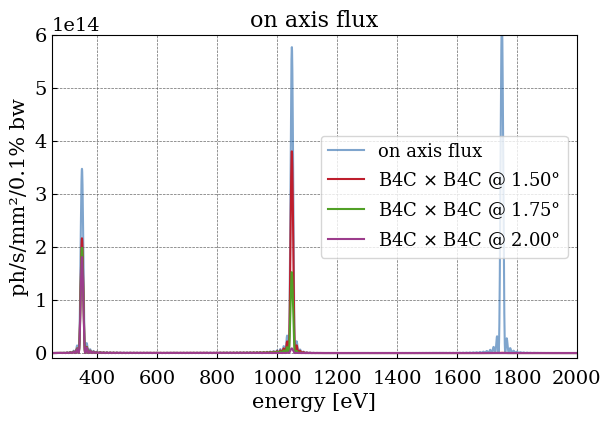

In [182]:
fig = PlotManager()
fig.image, fig.x = sp['spectrum']['flux'], sp['spectrum']['energy']
fig.additional_info("on axis flux", "energy [eV]", "ph/s/mm²/0.1% bw", xmin=250, xmax=2000, ymin=-1E13, ymax=6E14).aesthetics(LaTex=True, grid=True, PlotScale=0)
fig.info_1d_plot(0, 'on axis flux', LineStyle='-', alpha=0.5, LabelPos=0).plot_1d(enable=False)

fig.image = sp['spectrum']['flux']*C1['reflectivity']*C1['reflectivity']
fig.info_1d_plot(1,  f'{C1["material"]} $\\times$ {C1["material"]} @ {C1["theta"]:.2f}°', LineStyle='-', alpha=1).plot_1d(enable=False, hold=True)

fig.image = sp['spectrum']['flux']*C2['reflectivity']*C2['reflectivity']
fig.info_1d_plot(2,  f'{C2["material"]} $\\times$ {C2["material"]} @ {C2["theta"]:.2f}°', LineStyle='-', alpha=1).plot_1d(enable=False, hold=True)

fig.image = sp['spectrum']['flux']*C3['reflectivity']*C3['reflectivity']
fig.info_1d_plot(3,  f'{C3["material"]} $\\times$ {C3["material"]} @ {C3["theta"]:.2f}°', LineStyle='-', alpha=1).plot_1d(enable=True, hold=True)

## G1600

In [ ]:
M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
M3_II = reflectivity_curve("B4C", 2.52, 0.44, ei, ef, ne)

In [ ]:
fig = PlotManager()
fig.image, fig.x = M2, energy
fig.additional_info("M2 (Pt - G1600 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'cff = 0.2').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = M3['reflectivity'], energy
fig.additional_info("M3 (B$_4$C @ 0.44°)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, 'cff = 0.2 - Pt @ 1.2°', LineStyle=':', LabelPos=0).plot_1d(enable=False)
fig.image, fig.x = M3_II['reflectivity'], energy
fig.info_1d_plot(1, 'cff = 0.2 - B$_4$C @ 0.44°', LineStyle='-').plot_1d(enable=True, hold=True)


G1600_mono = G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2 * M3['reflectivity']
G1600_mono_II = G1600_cff0p2['carpem_G1600_VGD060A_c0p20']['h1'].values * M2 * M3_II['reflectivity']

fig = PlotManager()
fig.image, fig.x = G1600_mono, energy
fig.additional_info("G1600 (cff = 0.2) x M2 x M3", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.0415).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(2, 'current', LineStyle=':').plot_1d(enable=False)
fig.image, fig.x = G1600_mono_II, energy
fig.info_1d_plot(2, 'upgraded', LineStyle='-').plot_1d(enable=True, hold=True)

## G2400

In [ ]:
fig = PlotManager()
fig.image, fig.x = M2ML, energy
fig.additional_info("M2 (ML Mo$_2$C : B$_4$C - G2400 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, '$\Omega=0.692$').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = M3['reflectivity'], energy
fig.additional_info("M3 (B$_4$C @ 0.44°)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, '$\Omega=0.692$ - Pt @ 1.2°', LineStyle=':', LabelPos=0).plot_1d(enable=False)
fig.image, fig.x = M3_II['reflectivity'], energy
fig.info_1d_plot(1, '$\Omega=0.692$ - B$_4$C @ 0.44°', LineStyle='-').plot_1d(enable=True, hold=True)

G2400_mono = G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']
G2400_mono_II = G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3_II['reflectivity']

fig = PlotManager()
fig.image, fig.x = G2400_mono, energy
fig.additional_info("G2400 x M2(ML) x M3", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.1515).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(2, 'current', LineStyle=':').plot_1d(enable=False)
fig.image, fig.x = G2400_mono_II, energy
fig.info_1d_plot(2, 'upgraded', LineStyle='-').plot_1d(enable=True, hold=True)


## Focusing

In [ ]:
toroidal_mirror = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
elliptical_mirror = reflectivity_curve("B4C", 2.52, 0.44, ei, ef, ne)

Wolter = toroidal_mirror["reflectivity"]**2
KB = elliptical_mirror["reflectivity"]**2

fig = PlotManager()
fig.image, fig.x = Wolter, energy
fig.additional_info("KB throughput", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{toroidal_mirror["material"]} $\\times$ {toroidal_mirror["material"]} @ {toroidal_mirror["theta"]:.2f}°', LineStyle=':').plot_1d(enable=False)

fig.image, fig.x = KB, energy
fig.info_1d_plot(0, f'{elliptical_mirror["material"]} $\\times$ {elliptical_mirror["material"]} @ {elliptical_mirror["theta"]:.2f}°', LineStyle='-', LabelPos=0).plot_1d(enable=True, hold=True)

## Full beamline transmission

In [ ]:
fig = PlotManager()
fig.image, fig.x = LEG1600, energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.12).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2', LineStyle=':').plot_1d(enable=False)
fig.image = M1A_LE["reflectivity"]*M1B_LE["reflectivity"]*G1600_mono_II*KB
fig.info_1d_plot(0, 'B$_4$C$\\times$B$_4$C @ 1.75°', LineStyle='-').plot_1d(enable=False, hold=True)

fig.image = HEG1600
fig.info_1d_plot(1, 'HE/G1600/cff=0.2', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image = M1A_HE_P1["reflectivity"]*M1C_HE["reflectivity"]*G1600_mono_II*KB
fig.info_1d_plot(1, 'B$_4$C$\\times$Mo @ 0.75°', LineStyle='-').plot_1d(enable=False, hold=True)

# fig.image = M1A_HE_P2["reflectivity"]*M1C_HE["reflectivity"]*G1600_mono_II*KB
# fig.info_1d_plot(3, 'Mo$\\times$Mo @ 0.75°', LineStyle='--').plot_1d(enable=False, hold=True)

fig.image = HEG2400
fig.info_1d_plot(2, 'HE/G2400/$\Omega$=0.692', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image = M1A_HE_P1["reflectivity"]*M1C_HE["reflectivity"]*G2400_mono_II*KB
fig.info_1d_plot(2, 'B$_4$C$\\times$Mo @ 0.75°', LineStyle='-').plot_1d(enable=False, hold=True)
fig.image = M1A_HE_P2["reflectivity"]*M1C_HE["reflectivity"]*G2400_mono_II*KB
fig.info_1d_plot(3, 'Mo$\\times$Mo @ 0.75°', LineStyle='-').plot_1d(enable=True, hold=True)

## Transmitted photon flux

In [ ]:
tc = read_tuning_curve('.\\results\\source\\SOLEIL-II-U52mm_slit_tc.h5')

plot_tuning_curve(tc, unit="[ph/s/0.1%bw]", title='photon flux', prange=[e0, ef+(ei-e0), None, None])

In [ ]:
fig = PlotManager()
fig.image, fig.x = LEG1600*tc['flux'][:,0], energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=None, ymax=None).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2', LineStyle=':').plot_1d(enable=False)
fig.image = M1A_LE["reflectivity"]*M1B_LE["reflectivity"]*G1600_mono_II*KB*tc['flux'][:,0]
fig.info_1d_plot(0, 'B$_4$C$\\times$B$_4$C @ 1.75°', LineStyle='-').plot_1d(enable=False, hold=True)

fig.image = HEG1600*tc['flux'][:,0]
fig.info_1d_plot(1, 'HE/G1600/cff=0.2', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image = M1A_HE_P1["reflectivity"]*M1C_HE["reflectivity"]*G1600_mono_II*KB*tc['flux'][:,0]
fig.info_1d_plot(1, 'B$_4$C$\\times$Mo @ 0.75°', LineStyle='-').plot_1d(enable=False, hold=True)

# fig.image = M1A_HE_P2["reflectivity"]*M1C_HE["reflectivity"]*G1600_mono_II*KB
# fig.info_1d_plot(3, 'Mo$\\times$Mo @ 0.75°', LineStyle='--').plot_1d(enable=False, hold=True)

fig.image = HEG2400*tc['flux'][:,0]
fig.info_1d_plot(2, 'HE/G2400/$\Omega$=0.692', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image = M1A_HE_P1["reflectivity"]*M1C_HE["reflectivity"]*G2400_mono_II*KB*tc['flux'][:,0]
fig.info_1d_plot(2, 'B$_4$C$\\times$Mo @ 0.75°', LineStyle='-').plot_1d(enable=False, hold=True)
fig.image = M1A_HE_P2["reflectivity"]*M1C_HE["reflectivity"]*G2400_mono_II*KB*tc['flux'][:,0]
fig.info_1d_plot(3, 'Mo$\\times$Mo @ 0.75°', LineStyle='-').plot_1d(enable=True, hold=True)